In [ ]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn nltk
!pip install swifter
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=0db153be4b82df204c797d1a3892ed4afd14fa18caf24264b96073422cfe6f78
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
import swifter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from imblearn.over_sampling import SMOTE
from IPython import get_ipython
from IPython.display import display

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = '/content/drive/MyDrive/Dataset/Rev1_output_labelling.csv'
news = pd.read_csv(data, encoding= 'unicode_escape')
news

,tokoh,title,date,description,Rev1_label
0,anies baswedan,Anies Bertemu Relawan Pendukungnya di Australi...,"Senin, 06 Mar 2023 10:15 WIB",\-\n\nMantan Gubernur DKI Jakarta Anies Baswed...,1
1,anies baswedan,"PKS Bahagia Prabowo Bertemu Paloh: Bravo, Kian...","Senin, 06 Mar 2023 08:57 WIB",\-\n\nKetum Gerindra Prabowo Subianto bertemu ...,1
2,anies baswedan,Bos PPI Nilai Prabowo dan Paloh Sudah Siap Pis...,"Senin, 06 Mar 2023 09:00 WIB","\-\n\nDalam pertemuannya di Hambalang, Bogor, ...",1
3,anies baswedan,Riuh IMB Era Anies Diungkit PDIP Usai Kebakara...,"Senin, 06 Mar 2023 08:00 WIB",\-\n\nRiuh soal izin mendirikan bangunan (IMB)...,-1
4,anies baswedan,"Prabowo soal Anies: Siap Hadapi, Rakyat yang M...","Senin, 06 Mar 2023 08:55 WIB",\-\n\nBakal calon presiden dari Partai Gerindr...,0
...,...,...,...,...,...
877,prabowo,Prabowo 'Lawan' Anies Baswedan di Pilpres 2024...,"Senin, 06 Mar 2023 14:13 WIB",\-\n\nBakal calon presiden (Capres) Partai Ger...,1
878,prabowo,Terkini! Peta Kekuatan Prabowo dan Anies Jelan...,"Senin, 06 Mar 2023 13:47 WIB",\-\n\nDua bakal calon presiden Prabowo Subiant...,0
879,prabowo,NasDem Punya Tafsir Tersendiri soal Prabowo Si...,"Senin, 06 Mar 2023 16:18 WIB",\-\n\nCalon presiden Partai Gerindra Prabowo S...,0
880,prabowo,Duet Anies-Sandi Dinilai Kecil Kemungkinan Ter...,"Selasa, 07 Mar 2023 06:41 WIB",\-\n\nWacana duet Anies Baswedan dan Sandiaga ...,0


In [ ]:
print(news.columns)
news = news.drop(['date', 'A', 'B', 'C', 'label'], axis=1, errors='ignore')

Index(['tokoh', 'title', 'date', 'description', 'Rev1_label'], dtype='object')


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

ModuleNotFoundError: No module named 'Sastrawi'

In [ ]:
def preprocess(text):
    text = text.lower()  # Case folding
    text = re.sub(r'[-+]?[0-9]+', ' ', text)           # number
    text = re.sub(r"_", " ", text)
    text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\'," ")    # remove tab, new line, and back slice
    text = re.sub(r'((http|https)\:\/\/)[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', " ", text)
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())            # remove mention, link, hashtag
    text = re.sub(r'[^\w\s]',' ', text)                # punctuation
    text = re.sub('\s+',' ',text)                     # multiple whitespace into single whitespace
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    return text

### Case Folding

In [ ]:
def rev_space(text):
  text = re.sub('\s+',' ',text)
  return text

### Tokenizing

In [ ]:
def word_tokenizing(text):
    return word_tokenize(text)

### Stopword Removal

In [ ]:
def remove_stopwords(kata):
  stopwords_ind = stopwords.words('indonesian')
  stopwords_ind.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah', "detik", "detikjatim", "detikjateng",
                        "detikjabar", "detiksulsel", "detiksumbar", "detikbali",
                        "detikpapua", "detiksulteng", "detikmaluku", "detjatim",
                        "detikcom", "allahumma", "aamiin", "allah", "bismillah",
                        "20detik", "gambasvideo", 'simak', 'lengkap', 'sini', 'halaman','halaman selanjutnya'])
  stopwords_ind = set(stopwords_ind)
  return [word
            for word in kata
              if word not in stopwords_ind]

### Stemming

In [ ]:
def stemmed_wrapper(words):
  words = stemmer.stem(words)
  return words

In [ ]:
def stemmingText(document):
    return [term_dict.get(term, term) for term in document]

### Preprocessing Result

In [ ]:
news = news.copy()

In [ ]:
news['text'] = news['title'] + ' ' + news['description']

In [ ]:
news['case_folding'] = news['text'].apply(preprocess)
news['case_folding'] = news['case_folding'].apply(rev_space)
print(news[['text', 'case_folding']].head())

                                                text  \
0  Anies Bertemu Relawan Pendukungnya di Australi...   
1  PKS Bahagia Prabowo Bertemu Paloh: Bravo, Kian...   
2  Bos PPI Nilai Prabowo dan Paloh Sudah Siap Pis...   
3  Riuh IMB Era Anies Diungkit PDIP Usai Kebakara...   
4  Prabowo soal Anies: Siap Hadapi, Rakyat yang M...   

                                        case_folding  
0  anies bertemu relawan pendukungnya di australi...  
1  pks bahagia prabowo bertemu paloh bravo kian m...  
2  bos ppi nilai prabowo dan paloh sudah siap pis...  
3  riuh imb era anies diungkit pdip usai kebakara...  
4  prabowo soal anies siap hadapi rakyat yang mem...  


In [ ]:
news['tokenizing'] = news['case_folding'].apply(word_tokenizing)
print(news[['case_folding', 'tokenizing']].head())

                                        case_folding  \
0  anies bertemu relawan pendukungnya di australi...   
1  pks bahagia prabowo bertemu paloh bravo kian m...   
2  bos ppi nilai prabowo dan paloh sudah siap pis...   
3  riuh imb era anies diungkit pdip usai kebakara...   
4  prabowo soal anies siap hadapi rakyat yang mem...   

                                          tokenizing  
0  [anies, bertemu, relawan, pendukungnya, di, au...  
1  [pks, bahagia, prabowo, bertemu, paloh, bravo,...  
2  [bos, ppi, nilai, prabowo, dan, paloh, sudah, ...  
3  [riuh, imb, era, anies, diungkit, pdip, usai, ...  
4  [prabowo, soal, anies, siap, hadapi, rakyat, y...  


In [ ]:
news['stopword_removal'] = news['tokenizing'].apply(remove_stopwords)
print(news[['tokenizing', 'stopword_removal']].head())

                                          tokenizing  \
0  [anies, bertemu, relawan, pendukungnya, di, au...   
1  [pks, bahagia, prabowo, bertemu, paloh, bravo,...   
2  [bos, ppi, nilai, prabowo, dan, paloh, sudah, ...   
3  [riuh, imb, era, anies, diungkit, pdip, usai, ...   
4  [prabowo, soal, anies, siap, hadapi, rakyat, y...   

                                    stopword_removal  
0  [anies, bertemu, relawan, pendukungnya, austra...  
1  [pks, bahagia, prabowo, bertemu, paloh, bravo,...  
2  [bos, ppi, nilai, prabowo, paloh, pisah, jalan...  
3  [riuh, imb, era, anies, diungkit, pdip, kebaka...  
4  [prabowo, anies, hadapi, rakyat, memilih, calo...  


In [ ]:
term_dict = {}  # Initialize term_dict as an empty dictionary
for document in news['stopword_removal']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)

In [ ]:
news['stemming'] = news['stopword_removal'].apply(stemmingText)
print(news[['stopword_removal','stemming']].head())

                                    stopword_removal  \
0  [anies, bertemu, relawan, pendukungnya, austra...   
1  [pks, bahagia, prabowo, bertemu, paloh, bravo,...   
2  [bos, ppi, nilai, prabowo, paloh, pisah, jalan...   
3  [riuh, imb, era, anies, diungkit, pdip, kebaka...   
4  [prabowo, anies, hadapi, rakyat, memilih, calo...   

                                            stemming  
0  [anies, temu, rawan, dukung, australia, bahas,...  
1  [pks, bahagia, prabowo, temu, paloh, bravo, ki...  
2  [bos, ppi, nilai, prabowo, paloh, pisah, jalan...  
3  [riuh, imb, era, anies, ungkit, pdip, bakar, l...  
4  [prabowo, anies, hadap, rakyat, pilih, calon, ...  


In [ ]:
news['stemming_all_string'] = [','.join(map(str, l)) for l in news['stemming']]
print(news[['stemming','stemming_all_string']].head())

                                            stemming  \
0  [anies, temu, rawan, dukung, australia, bahas,...   
1  [pks, bahagia, prabowo, temu, paloh, bravo, ki...   
2  [bos, ppi, nilai, prabowo, paloh, pisah, jalan...   
3  [riuh, imb, era, anies, ungkit, pdip, bakar, l...   
4  [prabowo, anies, hadap, rakyat, pilih, calon, ...   

                                 stemming_all_string  
0  anies,temu,rawan,dukung,australia,bahas,mantan...  
1  pks,bahagia,prabowo,temu,paloh,bravo,kian,mulu...  
2  bos,ppi,nilai,prabowo,paloh,pisah,jalan,temu,h...  
3  riuh,imb,era,anies,ungkit,pdip,bakar,lahan,plu...  
4  prabowo,anies,hadap,rakyat,pilih,calon,preside...  


In [ ]:
news['case_folding'] = news['text'].apply(preprocess)
news['case_folding'] = news['case_folding'].apply(rev_space)
news['tokenizing'] = news['case_folding'].apply(word_tokenizing)
news['stopword_removal'] = news['tokenizing'].apply(remove_stopwords)
news['stemming'] = news['stopword_removal'].apply(stemmingText)
news['stemming_all_string'] = [','.join(map(str, l)) for l in news['stemming']]
news

,tokoh,title,description,Rev1_label,text,case_folding,tokenizing,stopword_removal,stemming,stemming_all_string
0,anies baswedan,Anies Bertemu Relawan Pendukungnya di Australi...,\-\n\nMantan Gubernur DKI Jakarta Anies Baswed...,1,Anies Bertemu Relawan Pendukungnya di Australi...,anies bertemu relawan pendukungnya di australi...,"[anies, bertemu, relawan, pendukungnya, di, au...","[anies, bertemu, relawan, pendukungnya, austra...","[anies, temu, rawan, dukung, australia, bahas,...","anies,temu,rawan,dukung,australia,bahas,mantan..."
1,anies baswedan,"PKS Bahagia Prabowo Bertemu Paloh: Bravo, Kian...",\-\n\nKetum Gerindra Prabowo Subianto bertemu ...,1,"PKS Bahagia Prabowo Bertemu Paloh: Bravo, Kian...",pks bahagia prabowo bertemu paloh bravo kian m...,"[pks, bahagia, prabowo, bertemu, paloh, bravo,...","[pks, bahagia, prabowo, bertemu, paloh, bravo,...","[pks, bahagia, prabowo, temu, paloh, bravo, ki...","pks,bahagia,prabowo,temu,paloh,bravo,kian,mulu..."
2,anies baswedan,Bos PPI Nilai Prabowo dan Paloh Sudah Siap Pis...,"\-\n\nDalam pertemuannya di Hambalang, Bogor, ...",1,Bos PPI Nilai Prabowo dan Paloh Sudah Siap Pis...,bos ppi nilai prabowo dan paloh sudah siap pis...,"[bos, ppi, nilai, prabowo, dan, paloh, sudah, ...","[bos, ppi, nilai, prabowo, paloh, pisah, jalan...","[bos, ppi, nilai, prabowo, paloh, pisah, jalan...","bos,ppi,nilai,prabowo,paloh,pisah,jalan,temu,h..."
3,anies baswedan,Riuh IMB Era Anies Diungkit PDIP Usai Kebakara...,\-\n\nRiuh soal izin mendirikan bangunan (IMB)...,-1,Riuh IMB Era Anies Diungkit PDIP Usai Kebakara...,riuh imb era anies diungkit pdip usai kebakara...,"[riuh, imb, era, anies, diungkit, pdip, usai, ...","[riuh, imb, era, anies, diungkit, pdip, kebaka...","[riuh, imb, era, anies, ungkit, pdip, bakar, l...","riuh,imb,era,anies,ungkit,pdip,bakar,lahan,plu..."
4,anies baswedan,"Prabowo soal Anies: Siap Hadapi, Rakyat yang M...",\-\n\nBakal calon presiden dari Partai Gerindr...,0,"Prabowo soal Anies: Siap Hadapi, Rakyat yang M...",prabowo soal anies siap hadapi rakyat yang mem...,"[prabowo, soal, anies, siap, hadapi, rakyat, y...","[prabowo, anies, hadapi, rakyat, memilih, calo...","[prabowo, anies, hadap, rakyat, pilih, calon, ...","prabowo,anies,hadap,rakyat,pilih,calon,preside..."
...,...,...,...,...,...,...,...,...,...,...
877,prabowo,Prabowo 'Lawan' Anies Baswedan di Pilpres 2024...,\-\n\nBakal calon presiden (Capres) Partai Ger...,1,Prabowo 'Lawan' Anies Baswedan di Pilpres 2024...,prabowo lawan anies baswedan di pilpres begini...,"[prabowo, lawan, anies, baswedan, di, pilpres,...","[prabowo, lawan, anies, baswedan, pilpres, pet...","[prabowo, lawan, anies, baswedan, pilpres, pet...","prabowo,lawan,anies,baswedan,pilpres,peta,kuat..."
878,prabowo,Terkini! Peta Kekuatan Prabowo dan Anies Jelan...,\-\n\nDua bakal calon presiden Prabowo Subiant...,0,Terkini! Peta Kekuatan Prabowo dan Anies Jelan...,terkini peta kekuatan prabowo dan anies jelang...,"[terkini, peta, kekuatan, prabowo, dan, anies,...","[terkini, peta, kekuatan, prabowo, anies, jela...","[kini, peta, kuat, prabowo, anies, jelang, pil...","kini,peta,kuat,prabowo,anies,jelang,pilpres,ca..."
879,prabowo,NasDem Punya Tafsir Tersendiri soal Prabowo Si...,\-\n\nCalon presiden Partai Gerindra Prabowo S...,0,NasDem Punya Tafsir Tersendiri soal Prabowo Si...,nasdem punya tafsir tersendiri soal prabowo si...,"[nasdem, punya, tafsir, tersendiri, soal, prab...","[nasdem, tafsir, tersendiri, prabowo, hadapi, ...","[nasdem, tafsir, sendiri, prabowo, hadap, anie...","nasdem,tafsir,sendiri,prabowo,hadap,anies,calo..."
880,prabowo,Duet Anies-Sandi Dinilai Kecil Kemungkinan Ter...,\-\n\nWacana duet Anies Baswedan dan Sandiaga ...,0,Duet Anies-Sandi Dinilai Kecil Kemungkinan Ter...,duet anies sandi dinilai kecil kemungkinan ter...,"[duet, anies, sandi, dinilai, kecil, kemungkin...","[duet, anies, sandi, dinilai, wacana, duet, an...","[duet, anies, sandi, nilai, wacana, duet, anie...","duet,anies,sandi,nilai,wacana,duet,anies,baswe..."


# TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), preprocessor=lambda x: x, token_pattern=None)
tfidf_features = tfidf_vectorizer.fit_transform(news['stemming_all_string'])

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(news['stemming_all_string'])
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaaaa', ..., 'zulkifliemansyah', 'zumarni', 'zumba'],
      dtype=object)

In [ ]:
df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
df

,aa,aaa,aaaaa,aaaaaagggggghhhhhh,aaaaaminn,aadc,aam,aan,aaron,abacus,...,zukifli,zul,zulfan,zulhaqqi,zulhas,zulkieflimansyah,zulkifli,zulkifliemansyah,zumarni,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

In [ ]:
def model_Evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

# Data Split

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

labels = news['Rev1_label']
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), preprocessor=lambda x: x, token_pattern=None)
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, labels, test_size=0.2, random_state=42)


### Decision Tree

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred)

print(f"Akurasi model: {accuracy_dt * 100:.2f}%") # Changed 'accuracy' to 'accuracy_dt'
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Akurasi model: 49.72%
              precision    recall  f1-score   support

          -1       0.58      0.45      0.51        42
           0       0.43      0.47      0.45        58
           1       0.52      0.55      0.53        77

    accuracy                           0.50       177
   macro avg       0.51      0.49      0.49       177
weighted avg       0.50      0.50      0.50       177

[[19  8 15]
 [ 7 27 24]
 [ 7 28 42]]


In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred, average='weighted')
recall_dt = recall_score(y_test, y_pred, average='weighted')
f1_dt = f1_score(y_test, y_pred, average='weighted')

print(f"Akurasi model   : {accuracy_dt * 100:.2f}%")
print(f"Precision       : {precision_dt * 100:.2f}%")
print(f"Recall          : {recall_dt * 100:.2f}%")
print(f"F1 Score        : {f1_dt * 100:.2f}%")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Akurasi model   : 49.72%
Precision       : 50.26%
Recall          : 49.72%
F1 Score        : 49.77%
              precision    recall  f1-score   support

          -1       0.58      0.45      0.51        42
           0       0.43      0.47      0.45        58
           1       0.52      0.55      0.53        77

    accuracy                           0.50       177
   macro avg       0.51      0.49      0.49       177
weighted avg       0.50      0.50      0.50       177

[[19  8 15]
 [ 7 27 24]
 [ 7 28 42]]


### Random Forest

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')

print(f"Akurasi model   : {accuracy_rf * 100:.2f}%")
print(f"Precision       : {precision_rf * 100:.2f}%")
print(f"Recall          : {recall_rf * 100:.2f}%")
print(f"F1 Score        : {f1_rf * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Akurasi model   : 62.15%
Precision       : 66.74%
Recall          : 62.15%
F1 Score        : 59.34%

Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.52      0.61        42
           0       0.75      0.31      0.44        58
           1       0.57      0.91      0.70        77

    accuracy                           0.62       177
   macro avg       0.68      0.58      0.58       177
weighted avg       0.67      0.62      0.59       177

Confusion Matrix:
[[22  2 18]
 [ 5 18 35]
 [ 3  4 70]]


### XGBoost

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.validation import column_or_1d

label_mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train_mapped)
y_pred_xgb_mapped = xgb_classifier.predict(X_test)


accuracy_xgb = accuracy_score(y_test_mapped, y_pred_xgb_mapped)
print(f"\nAkurasi XGBoost: {accuracy_xgb * 100:.2f}%")
print(classification_report(y_test_mapped, y_pred_xgb_mapped, target_names=['-1', '0', '1'], zero_division=0))
print(confusion_matrix(y_test_mapped, y_pred_xgb_mapped))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:27:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Akurasi XGBoost: 62.71%
              precision    recall  f1-score   support

          -1       0.70      0.50      0.58        42
           0       0.67      0.45      0.54        58
           1       0.59      0.83      0.69        77

    accuracy                           0.63       177
   macro avg       0.65      0.59      0.60       177
weighted avg       0.64      0.63      0.62       177

[[21  3 18]
 [ 6 26 26]
 [ 3 10 64]]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.validation import column_or_1d

# Label mapping
label_mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# Training XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train_mapped)

# Prediction
y_pred_xgb_mapped = xgb_classifier.predict(X_test)

# Metrics
accuracy_xgb = accuracy_score(y_test_mapped, y_pred_xgb_mapped)
precision_xgb = precision_score(y_test_mapped, y_pred_xgb_mapped, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test_mapped, y_pred_xgb_mapped, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test_mapped, y_pred_xgb_mapped, average='weighted', zero_division=0)

# Print results
print(f"\nAkurasi XGBoost : {accuracy_xgb * 100:.2f}%")
print(f"Precision       : {precision_xgb * 100:.2f}%")
print(f"Recall          : {recall_xgb * 100:.2f}%")
print(f"F1 Score        : {f1_xgb * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test_mapped, y_pred_xgb_mapped, target_names=['-1', '0', '1'], zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test_mapped, y_pred_xgb_mapped))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Akurasi XGBoost : 62.71%
Precision       : 64.24%
Recall          : 62.71%
F1 Score        : 61.51%

Classification Report:
              precision    recall  f1-score   support

          -1       0.70      0.50      0.58        42
           0       0.67      0.45      0.54        58
           1       0.59      0.83      0.69        77

    accuracy                           0.63       177
   macro avg       0.65      0.59      0.60       177
weighted avg       0.64      0.63      0.62       177

Confusion Matrix:
[[21  3 18]
 [ 6 26 26]
 [ 3 10 64]]


# Kfold Cross Validation

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

labels = news['Rev1_label']
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])

X = tfidf_features
y = labels

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
param_grid_rf = {
    'n_estimators': [100, 200,300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Decision Tree

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

labels = news['Rev1_label']
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])

X = tfidf_features
y = labels

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)


accuracies = []
precisions = []
recalls = []
f1_scores = []

fold = 1
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    dt = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("  Best Parameters:", grid_search.best_params_)

    val_pred = best_model.predict(X_val)

    accuracy = accuracy_score(y_val, val_pred)
    precision = precision_score(y_val, val_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, val_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, val_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_val, val_pred)

    # Simpan ke list
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Fold {fold}:")
    print(f"  Accuracy : {accuracy * 100:.2f}%")
    print(f"  Precision: {precision * 100:.2f}%")
    print(f"  Recall   : {recall * 100:.2f}%")
    print(f"  F1 Score : {f1 * 100:.2f}%")
    print("  Confusion Matrix:")
    print(cm)
    print()

    fold += 1

# Cetak rata-rata skor akhir
print("Final Average Results:")
print(f"  Accuracy : {np.mean(accuracies) * 100:.2f}%")
print(f"  Precision: {np.mean(precisions) * 100:.2f}%")
print(f"  Recall   : {np.mean(recalls) * 100:.2f}%")
print(f"  F1 Score : {np.mean(f1_scores) * 100:.2f}%")
print("  Best Parameters:", grid_search.best_params_)

  Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Fold 1:
  Accuracy : 53.67%
  Precision: 54.34%
  Recall   : 53.67%
  F1 Score : 52.01%
  Confusion Matrix:
[[20  5 17]
 [ 5 17 36]
 [ 3 16 58]]

  Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Fold 2:
  Accuracy : 46.33%
  Precision: 46.73%
  Recall   : 46.33%
  F1 Score : 44.72%
  Confusion Matrix:
[[13 10 17]
 [ 5 16 38]
 [ 3 22 53]]

  Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Fold 3:
  Accuracy : 55.11%
  Precision: 53.82%
  Recall   : 55.11%
  F1 Score : 48.29%
  Confusion Matrix:
[[17  3 18]
 [ 3  5 46]
 [ 6  3 75]]

  Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Fold 4:
  Accuracy : 53.41%
  Precision: 48.40%
  Recall   : 53.41%
  F1 Score : 47.65%
  Confusion Matrix:
[[19  3 17]
 [ 4  4 44]
 [

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(dt_classifier, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X, y)
print(f"Best Hyperparameter : {grid_search_dt.best_params_}")


best_dt_model = grid_search_dt.best_estimator_

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(best_dt_model, X, y, cv=kf)

accuracy_dt = accuracy_score(y, y_pred)
precision_dt = precision_score(y, y_pred, average='weighted', zero_division=0)
recall_dt = recall_score(y, y_pred, average='weighted', zero_division=0)
f1_dt = f1_score(y, y_pred, average='weighted', zero_division=0)

print(f"Akurasi model   : {accuracy_dt * 100:.2f}%")
print(f"Precision       : {precision_dt * 100:.2f}%")
print(f"Recall          : {recall_dt * 100:.2f}%")
print(f"F1 Score        : {f1_dt * 100:.2f}%")

print(classification_report(y, y_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
score_value = best_dt_model.score(X, y)
print(f"Score Value (Akurasi model di seluruh dataset): {score_value * 100:.2f}%")

Best Hyperparameter : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Akurasi model   : 53.17%
Precision       : 50.03%
Recall          : 53.17%
F1 Score        : 44.01%
              precision    recall  f1-score   support

          -1       0.68      0.40      0.51       188
           0       0.35      0.04      0.07       283
           1       0.52      0.93      0.66       411

    accuracy                           0.53       882
   macro avg       0.52      0.46      0.41       882
weighted avg       0.50      0.53      0.44       882

Confusion Matrix:
[[ 76   7 105]
 [ 19  11 253]
 [ 16  13 382]]
Score Value (Akurasi model di seluruh dataset): 59.98%


### Random Forest

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

labels = news['Rev1_label']
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])

X = tfidf_features
y = labels

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List untuk simpan skor per fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

fold = 1
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("  Best Parameters:", grid_search.best_params_)

    val_pred = best_model.predict(X_val)

    accuracy = accuracy_score(y_val, val_pred)
    precision = precision_score(y_val, val_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, val_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, val_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_val, val_pred)

    # Simpan ke list
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Fold {fold}:")
    print(f"  Accuracy : {accuracy * 100:.2f}%")
    print(f"  Precision: {precision * 100:.2f}%")
    print(f"  Recall   : {recall * 100:.2f}%")
    print(f"  F1 Score : {f1 * 100:.2f}%")
    print("  Confusion Matrix:")
    print(cm)
    print()

    fold += 1

# Cetak rata-rata skor akhir
print("Final Average Results:")
print(f"  Accuracy : {np.mean(accuracies) * 100:.2f}%")
print(f"  Precision: {np.mean(precisions) * 100:.2f}%")
print(f"  Recall   : {np.mean(recalls) * 100:.2f}%")
print(f"  F1 Score : {np.mean(f1_scores) * 100:.2f}%")
print("  Best Parameters:", grid_search.best_params_)

  Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1:
  Accuracy : 61.58%
  Precision: 62.66%
  Recall   : 61.58%
  F1 Score : 59.17%
  Confusion Matrix:
[[21  5 16]
 [ 8 20 30]
 [ 3  6 68]]

  Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Fold 2:
  Accuracy : 55.93%
  Precision: 63.44%
  Recall   : 55.93%
  F1 Score : 52.08%
  Confusion Matrix:
[[13  2 25]
 [ 1 16 42]
 [ 1  7 70]]

  Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 3:
  Accuracy : 66.48%
  Precision: 68.16%
  Recall   : 66.48%
  F1 Score : 65.43%
  Confusion Matrix:
[[22  2 14]
 [ 2 24 28]
 [ 2 11 71]]

  Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 4:
  Accuracy : 68.18%
  Precision: 69.83%
  Recall

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X, y)
print(f"Best Hyperparameter : {grid_search_rf.best_params_}")

best_rf_model = grid_search_rf.best_estimator_

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(best_rf_model, X, y, cv=kf)

accuracy_rf = accuracy_score(y, y_pred)
precision_rf = precision_score(y, y_pred, average='weighted', zero_division=0)
recall_rf = recall_score(y, y_pred, average='weighted', zero_division=0)
f1_rf = f1_score(y, y_pred, average='weighted', zero_division=0)

print(f"Akurasi model   : {accuracy_rf * 100:.2f}%")
print(f"Precision       : {precision_rf * 100:.2f}%")
print(f"Recall          : {recall_rf * 100:.2f}%")
print(f"F1 Score        : {f1_rf * 100:.2f}%")

print(classification_report(y, y_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
score_value = best_rf_model.score(X, y)
print(f"Score Value (Akurasi model di seluruh dataset): {score_value * 100:.2f}%")

Best Hyperparameter : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Akurasi model   : 63.72%
Precision       : 65.06%
Recall          : 63.72%
F1 Score        : 62.17%
              precision    recall  f1-score   support

          -1       0.81      0.55      0.65       188
           0       0.60      0.39      0.47       283
           1       0.61      0.85      0.71       411

    accuracy                           0.64       882
   macro avg       0.67      0.60      0.61       882
weighted avg       0.65      0.64      0.62       882

Confusion Matrix:
[[103  20  65]
 [ 14 110 159]
 [ 10  52 349]]
Score Value (Akurasi model di seluruh dataset): 97.85%


### XGBoost

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.validation import column_or_1d

In [ ]:
labels = news['Rev1_label']
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])

X = tfidf_features
y = labels
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

label_mapping = {-1: 0, 0: 1, 1: 2}
y = y.map(label_mapping)


xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X, y)
print(f"Best Parameters: {grid_search_xgb.best_params_}")

best_xgb_model = grid_search_xgb.best_estimator_

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(best_xgb_model, X, y, cv=kf)

accuracy_xgbg = accuracy_score(y, y_pred)
precision_xgb = precision_score(y, y_pred, average='weighted', zero_division=0)
recall_xgb = recall_score(y, y_pred, average='weighted', zero_division=0)
f1_xgb = f1_score(y, y_pred, average='weighted', zero_division=0)

print(f"Accuracy        : {accuracy_xgb * 100:.2f}%")
print(f"Precision       : {precision_xgb * 100:.2f}%")
print(f"Recall          : {recall_xgb * 100:.2f}%")
print(f"F1 Score        : {f1_xgb * 100:.2f}%")

print(classification_report(y, y_pred, zero_division=0))
print(confusion_matrix(y, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:06:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:06:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:06:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:06:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:07:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:07:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Accuracy        : 62.71%
Precision       : 60.65%
Recall          : 60.77%
F1 Score        : 60.15%
              precision    recall  f1-score   support

           0       0.70      0.55      0.62       188
           1       0.52      0.44      0.48       283
           2       0.62      0.75      0.68       411

    accuracy                           0.61       882
   macro avg       0.61      0.58      0.59       882
weighted avg       0.61      0.61      0.60       882

[[104  31  53]
 [ 24 125 134]
 [ 20  84 307]]


In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

label_mapping = {-1: 0, 0: 1, 1: 2}
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])
y = news['Rev1_label'].map(label_mapping)
X = tfidf_features

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []
best_params_list = []

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    grid_search = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params_list.append(grid_search.best_params_)

    val_pred = best_model.predict(X_val)

    accuracies.append(accuracy_score(y_val, val_pred))
    precisions.append(precision_score(y_val, val_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(y_val, val_pred, average='weighted', zero_division=0))
    f1_scores.append(f1_score(y_val, val_pred, average='weighted', zero_division=0))

# Print only final average results
print("Final Average Results:")
print(f"  Accuracy : {np.mean(accuracies) * 100:.2f}%")
print(f"  Precision: {np.mean(precisions) * 100:.2f}%")
print(f"  Recall   : {np.mean(recalls) * 100:.2f}%")
print(f"  F1 Score : {np.mean(f1_scores) * 100:.2f}%")
print("  Most Common Best Parameters:", max(set(tuple(d.items()) for d in best_params_list), key=best_params_list.count))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:57:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:03:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:11:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

label_mapping = {-1: 0, 0: 1, 1: 2}
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])
y = news['Rev1_label'].map(label_mapping)
X = tfidf_features

# Parameter grid untuk XGBoost
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List untuk simpan skor per fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

fold = 1
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    grid_search = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("  Best Parameters:", grid_search.best_params_)
    val_pred = best_model.predict(X_val)

    accuracy = accuracy_score(y_val, val_pred)
    precision = precision_score(y_val, val_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, val_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, val_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_val, val_pred)

    # Simpan ke list
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Fold {fold}:")
    print(f"  Accuracy : {accuracy * 100:.2f}%")
    print(f"  Precision: {precision * 100:.2f}%")
    print(f"  Recall   : {recall * 100:.2f}%")
    print(f"  F1 Score : {f1 * 100:.2f}%")
    print("  Confusion Matrix:")
    print(cm)
    print()

    fold += 1

# Cetak rata-rata skor akhir
print("Final Average Results:")
print(f"  Accuracy : {np.mean(accuracies) * 100:.2f}%")
print(f"  Precision: {np.mean(precisions) * 100:.2f}%")
print(f"  Recall   : {np.mean(recalls) * 100:.2f}%")
print(f"  F1 Score : {np.mean(f1_scores) * 100:.2f}%")
print("  Best Parameters:", grid_search.best_params_)

KeyboardInterrupt: 

# SMOTE

### Decision Tree

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [ ]:
labels = news['Rev1_label']
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])

X = tfidf_features
y = labels

def evaluate_smote_on_train(X, y, model, description):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"=== {description} ===")
    print(f"Akurasi model   : {accuracy * 100:.2f}%")
    print(f"Precision       : {precision * 100:.2f}%")
    print(f"Recall          : {recall * 100:.2f}%")
    print(f"F1 Score        : {f1 * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(conf_matrix)

dt_classifier = DecisionTreeClassifier(random_state=42)
evaluate_smote_on_train(X, y, dt_classifier, "Decision Tree with SMOTE on Training Data Only")

=== Decision Tree with SMOTE on Training Data Only ===
Akurasi model   : 55.93%
Precision       : 56.82%
Recall          : 55.93%
F1 Score        : 55.83%
Classification Report:
              precision    recall  f1-score   support

          -1       0.59      0.68      0.63        38
           0       0.49      0.58      0.53        57
           1       0.62      0.49      0.54        82

    accuracy                           0.56       177
   macro avg       0.56      0.58      0.57       177
weighted avg       0.57      0.56      0.56       177

Confusion Matrix:
[[26  5  7]
 [ 6 33 18]
 [12 30 40]]


### Random Forest

In [ ]:
labels = news['Rev1_label']
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])

X = tfidf_features
y = labels

def evaluate_smote(X, y, model, description):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y # Stratify berdasarkan y asli
    )
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"=== {description} ===")
    print(f"Accuracy        : {accuracy * 100:.2f}%") # Menghapus baris duplikat 'Akurasi model'
    print(f"Precision       : {precision * 100:.2f}%")
    print(f"Recall          : {recall * 100:.2f}%")
    print(f"F1 Score        : {f1 * 100:.2f}%")
    print("\nClassification Report:") # Menambahkan newline untuk keterbacaan
    print(classification_report(y_test, y_pred, zero_division=0))
    print("\nConfusion Matrix:") # Menambahkan newline untuk keterbacaan
    print(conf_matrix)

rf_classifier = RandomForestClassifier(random_state=42)
evaluate_smote(X, y, rf_classifier, "Random Forest with SMOTE on Training Data")

=== Random Forest with SMOTE on Training Data ===
Accuracy        : 65.54%
Precision       : 65.92%
Recall          : 65.54%
F1 Score        : 65.45%

Classification Report:
              precision    recall  f1-score   support

          -1       0.77      0.63      0.70        38
           0       0.59      0.56      0.58        57
           1       0.65      0.73      0.69        82

    accuracy                           0.66       177
   macro avg       0.67      0.64      0.65       177
weighted avg       0.66      0.66      0.65       177


Confusion Matrix:
[[24  6  8]
 [ 1 32 24]
 [ 6 16 60]]


### XGBoost

In [ ]:
labels = news['Rev1_label']
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])

X = tfidf_features
y = labels

label_mapping = {-1: 0, 0: 1, 1: 2}
y_mapped = y.map(label_mapping)

def evaluate_smote(X, y_mapped, model, description):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped
    )

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    original_labels = sorted(label_mapping, key=label_mapping.get)

    print(f"=== {description} ===")
    print(f"Accuracy        : {accuracy * 100:.2f}%")
    print(f"Precision       : {precision * 100:.2f}%")
    print(f"Recall          : {recall * 100:.2f}%")
    print(f"F1 Score        : {f1 * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0, target_names=[str(l) for l in original_labels])) # Mengubah int ke string
    print("\nConfusion Matrix:")
    print(conf_matrix)

xgb_classifier = XGBClassifier(random_state=42)
evaluate_smote(X, y_mapped, xgb_classifier, "XGBoost with SMOTE on Training Data")

=== XGBoost with SMOTE on Training Data ===
Accuracy        : 63.84%
Precision       : 64.05%
Recall          : 63.84%
F1 Score        : 63.92%

Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.71      0.71        38
           0       0.55      0.58      0.56        57
           1       0.67      0.65      0.66        82

    accuracy                           0.64       177
   macro avg       0.64      0.65      0.64       177
weighted avg       0.64      0.64      0.64       177


Confusion Matrix:
[[27  5  6]
 [ 4 33 20]
 [ 7 22 53]]


# Grafik

### Decision Tree

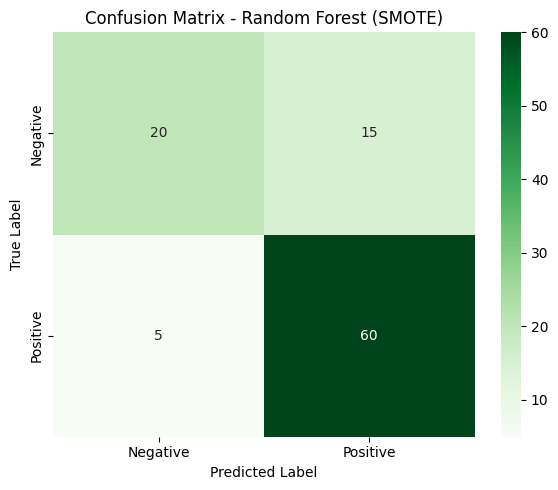

In [ ]:
cm = confusion_matrix(y_true, y_pred)
labels = ['Negative', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest (SMOTE)')
plt.tight_layout()
plt.show()


Fold 1:
  Best Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
  Train Accuracy: 0.5957
  Validation Accuracy: 0.5141



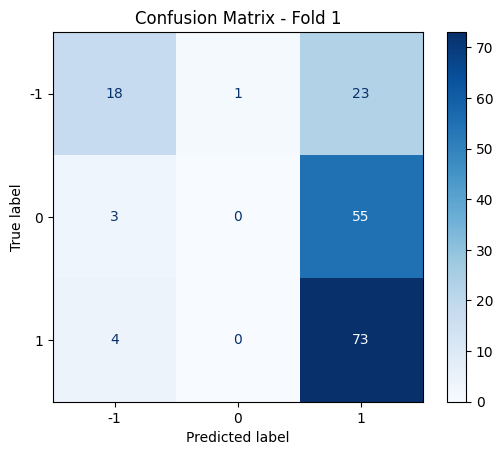

Fold 2:
  Best Params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Train Accuracy: 0.6085
  Validation Accuracy: 0.5085



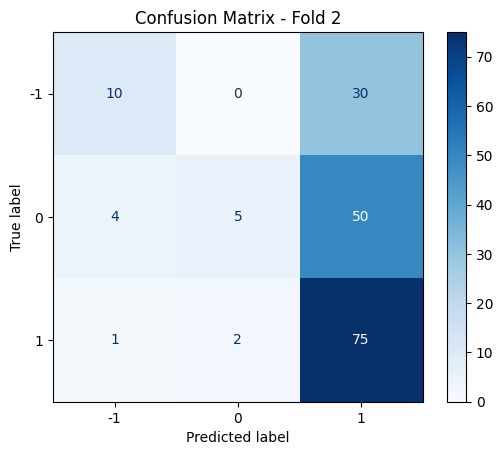

Fold 3:
  Best Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Train Accuracy: 0.6006
  Validation Accuracy: 0.5568



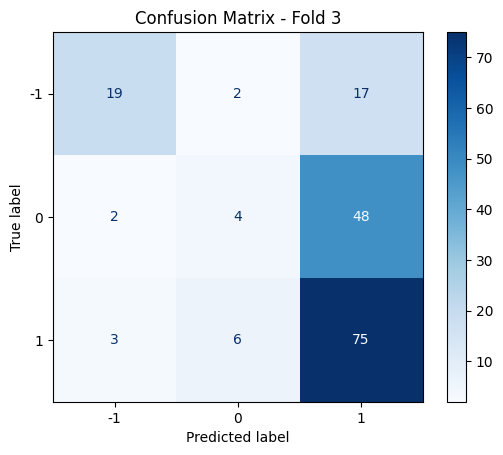

Fold 4:
  Best Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
  Train Accuracy: 0.5822
  Validation Accuracy: 0.5625



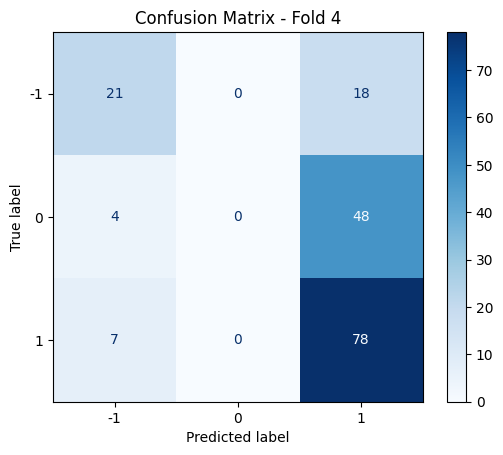

Fold 5:
  Best Params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
  Train Accuracy: 0.5935
  Validation Accuracy: 0.5398



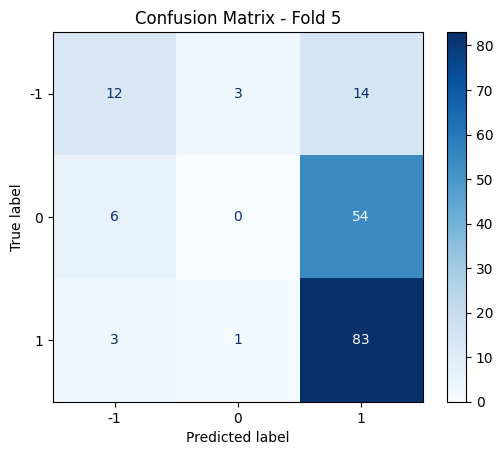

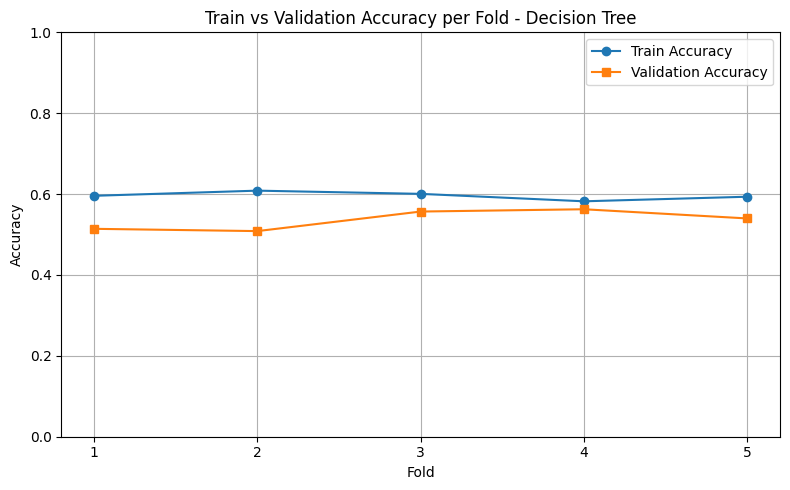

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
labels = news['Rev1_label']
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])

X = tfidf_features
y = labels

# Parameter grid untuk GridSearch
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

train_accuracies = []
val_accuracies = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    dt = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    train_pred = best_model.predict(X_train)
    val_pred = best_model.predict(X_val)

    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Fold {fold}:")
    print(f"  Best Params: {grid_search.best_params_}")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}\n")

    # Confusion matrix untuk validation set
    cm = confusion_matrix(y_val, val_pred, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.grid(False)
    plt.show()

    fold += 1

# Plot grafik akurasi
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, 6), val_accuracies, marker='s', label='Validation Accuracy')
plt.title('Train vs Validation Accuracy per Fold - Decision Tree')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(range(1, 6))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Akurasi: 0.5593
Classification Report:
               precision    recall  f1-score   support

          -1       0.59      0.68      0.63        38
           0       0.49      0.58      0.53        57
           1       0.62      0.49      0.54        82

    accuracy                           0.56       177
   macro avg       0.56      0.58      0.57       177
weighted avg       0.57      0.56      0.56       177



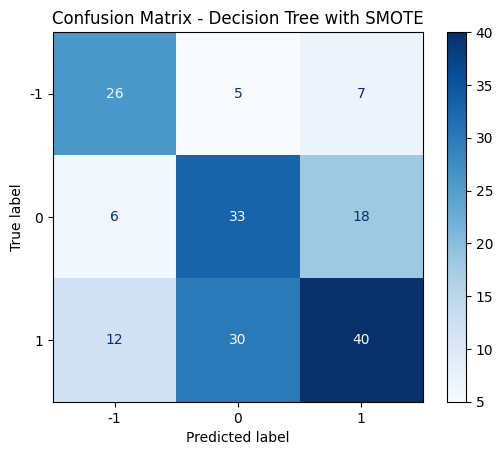

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(news['stemming_all_string'])
y = news['Rev1_label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE hanya di data training
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

# Predict di test set
y_pred = dt_model.predict(X_test)

# Evaluasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree with SMOTE")
plt.grid(False)
plt.show()


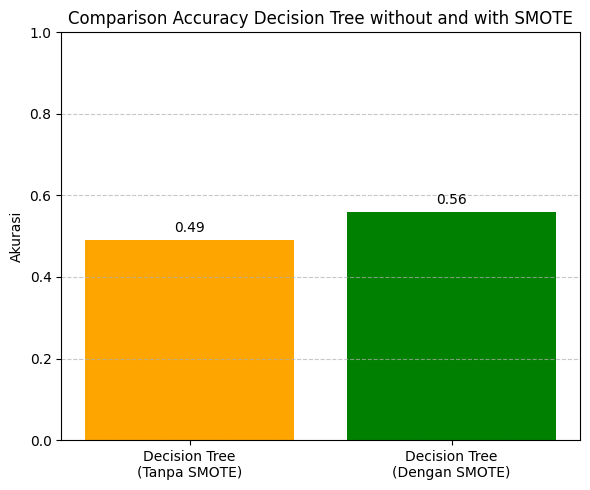

In [ ]:
import matplotlib.pyplot as plt

accuracy_before_smote = 0.49
accuracy_after_smote = accuracy

models = ['Decision Tree\n(Tanpa SMOTE)', 'Decision Tree\n(Dengan SMOTE)']
accuracies = [accuracy_before_smote, accuracy_after_smote]

plt.figure(figsize=(6, 5))
bars = plt.bar(models, accuracies, color=['orange', 'green'])
plt.ylim(0, 1)
plt.ylabel('Akurasi')
plt.title('Comparison Accuracy Decision Tree without and with SMOTE')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


### Random Forest

Fold 1:
  Best Params: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Train Accuracy: 0.9830
  Validation Accuracy: 0.6215



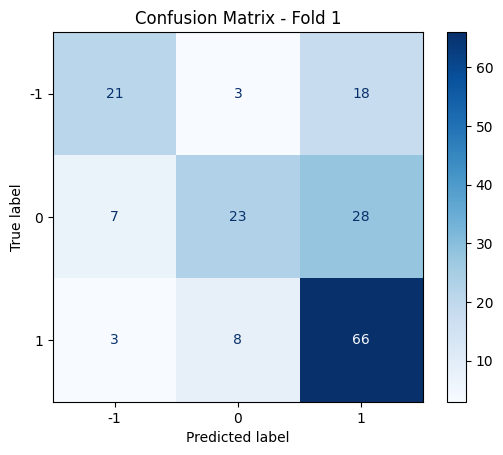

Fold 2:
  Best Params: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
  Train Accuracy: 0.9291
  Validation Accuracy: 0.6158



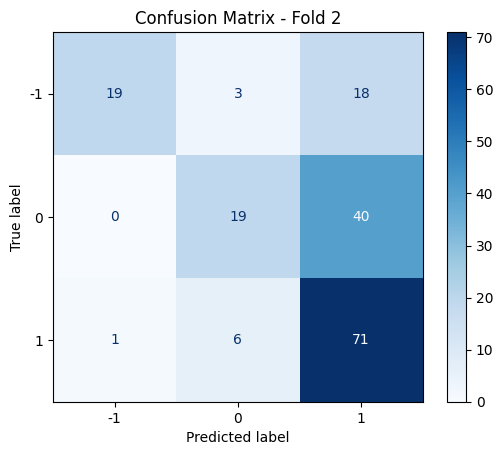

Fold 3:
  Best Params: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
  Train Accuracy: 0.9773
  Validation Accuracy: 0.6534



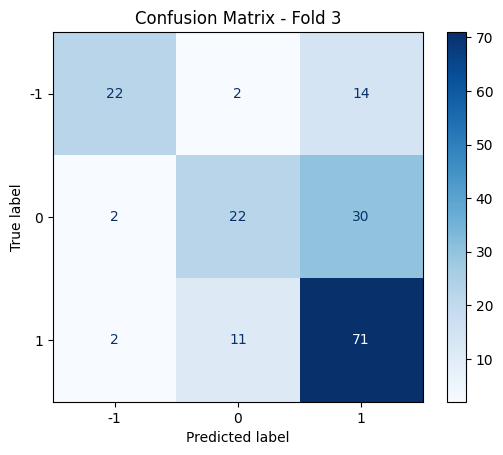

Fold 4:
  Best Params: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
  Train Accuracy: 0.9773
  Validation Accuracy: 0.6364



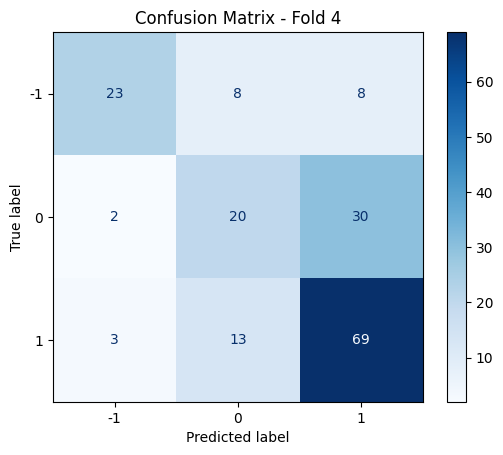

Fold 5:
  Best Params: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
  Train Accuracy: 0.9589
  Validation Accuracy: 0.6193



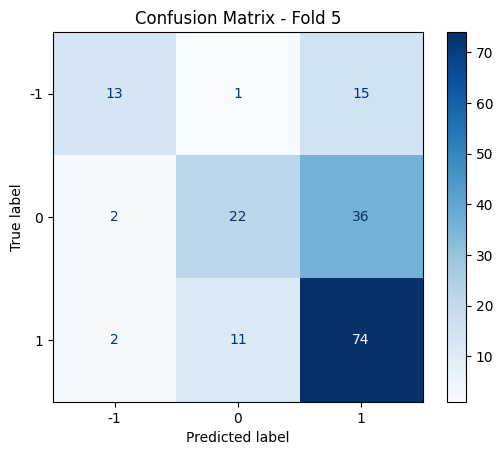

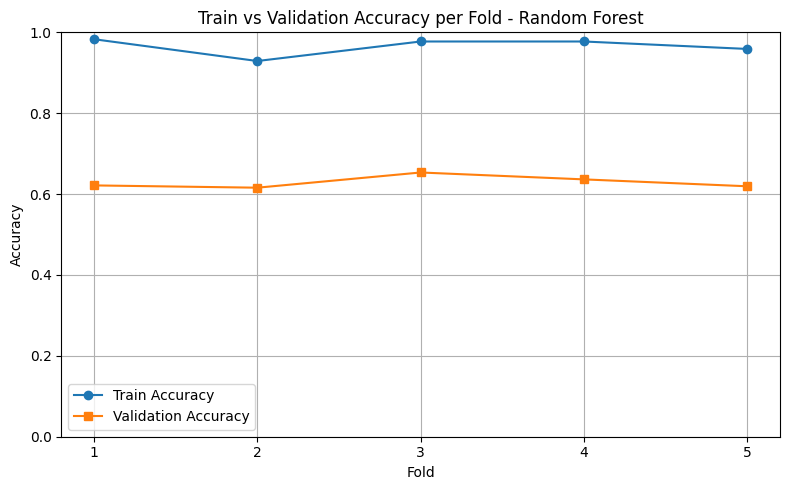

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
labels = news['Rev1_label']
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(news['stemming_all_string'])

X = tfidf_features
y = labels

param_grid_rf = {
    'n_estimators': [100, 200,300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
}
train_accuracies = []
val_accuracies = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    train_pred = best_model.predict(X_train)
    val_pred = best_model.predict(X_val)

    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Fold {fold}:")
    print(f"  Best Params: {grid_search.best_params_}")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}\n")

    # Confusion matrix untuk validation set
    cm = confusion_matrix(y_val, val_pred, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.grid(False)
    plt.show()

    fold += 1

# Plot grafik akurasi
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, 6), val_accuracies, marker='s', label='Validation Accuracy')
plt.title('Train vs Validation Accuracy per Fold - Random Forest')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(range(1, 6))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Akurasi: 0.6554
Classification Report:
               precision    recall  f1-score   support

          -1       0.77      0.63      0.70        38
           0       0.59      0.56      0.58        57
           1       0.65      0.73      0.69        82

    accuracy                           0.66       177
   macro avg       0.67      0.64      0.65       177
weighted avg       0.66      0.66      0.65       177



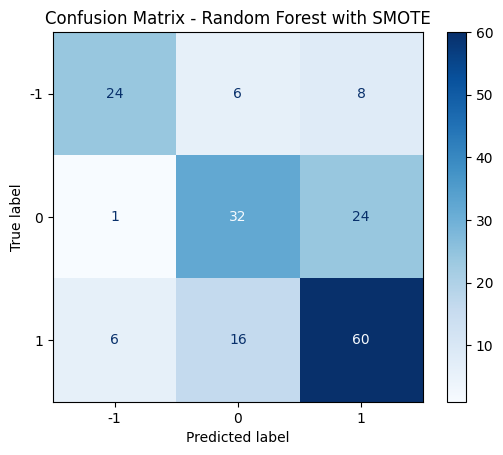

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(news['stemming_all_string'])
y = news['Rev1_label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE hanya di data training
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Decision Tree
dt_model = RandomForestClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

# Predict di test set
y_pred = dt_model.predict(X_test)

# Evaluasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest with SMOTE")
plt.grid(False)
plt.show()


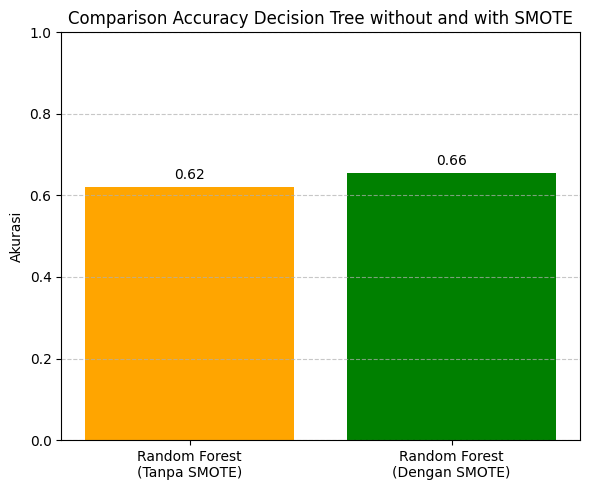

In [ ]:
import matplotlib.pyplot as plt

accuracy_before_smote = 0.62
accuracy_after_smote = accuracy

models = ['Random Forest\n(Tanpa SMOTE)', 'Random Forest\n(Dengan SMOTE)']
accuracies = [accuracy_before_smote, accuracy_after_smote]

plt.figure(figsize=(6, 5))
bars = plt.bar(models, accuracies, color=['orange', 'green'])
plt.ylim(0, 1)
plt.ylabel('Akurasi')
plt.title('Comparison Accuracy Decision Tree without and with SMOTE')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


### XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:59:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:59:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:59:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:59:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:59:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

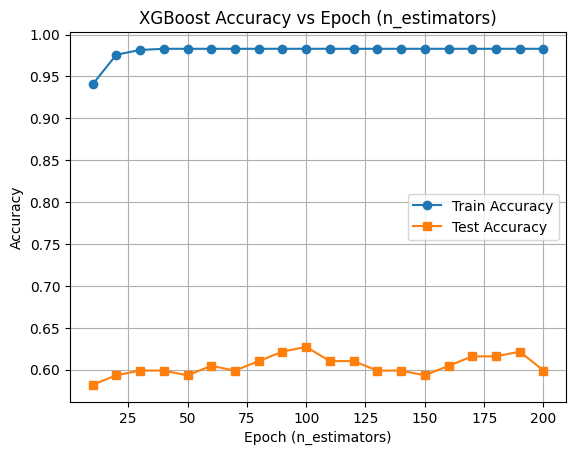

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(news['stemming_all_string'])
y = news['Rev1_label']

# Mapping label agar cocok dengan XGBoost
label_mapping = {-1: 0, 0: 1, 1: 2}
y_mapped = y.map(label_mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42)

# Simulasi "epoch" via n_estimators
train_scores = []
test_scores = []
epochs = range(10, 201, 10)

for n in epochs:
    model = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    model.fit(X_train, y_train)

    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

# Plot
plt.plot(epochs, train_scores, label='Train Accuracy', marker='o')
plt.plot(epochs, test_scores, label='Test Accuracy', marker='s')
plt.title('XGBoost Accuracy vs Epoch (n_estimators)')
plt.xlabel('Epoch (n_estimators)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
